In [1]:
from sklearn import metrics
import joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [4]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

2025-05-02 19:14:18.424764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 19:14:18.691445: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 19:14:19.676701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-05-02 19:14:19.676882: W

In [5]:
import pytz
from datetime import timedelta, datetime
local_tz = pytz.timezone('America/Toronto') # Set local timezone for InfluxDB based times calculations
today=datetime.today().strftime('%Y-%m-%d')

#### Note: if you did not create new data for the model training, a sample is provided in this repository. 
#### To use it, ensure that in the next cell the instruction with the file name lt_results_2022-10-01.csv in it is executed and not the one using "today's" date

In [6]:
#data = pd.read_csv('lt_results_'+today+'.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)
data = pd.read_csv('lt_results_2022-10-01.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)

In [7]:
data.head()

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,req2xx,testDurationSeconds,timeoutSeconds
DateTime,,,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,50679.0,165.0,5.0
2022-09-28 15:34:42+00:00,True,30.0,173.0,2788.0,158.0,1.0,347.427221,35.0,146793.0,423.0,5.0
2022-09-28 15:47:10+00:00,True,28.0,125.0,1411.0,110.0,15.0,138.693699,14.0,84757.0,611.0,5.0
2022-09-28 15:56:35+00:00,True,14.0,115.0,1176.0,100.0,12.0,158.212165,16.0,68515.0,433.0,5.0
2022-09-28 16:01:09+00:00,True,30.0,226.0,2296.0,211.0,12.0,245.806605,25.0,34173.0,139.0,5.0


In [8]:
data = data.drop(columns=['req2xx', 'testDurationSeconds'])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data.mean_tps,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((74, 9), (9, 9))

In [10]:
target_var = 'mean_tps'
X_train = X_train.drop(target_var, axis=1)
X_test = X_test.drop(target_var, axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
stdScaler = StandardScaler()
targetStdScaler = StandardScaler()

In [13]:
X_train_scaled = stdScaler.fit_transform(X_train.values)
y_train_scaled = targetStdScaler.fit_transform(y_train.values.reshape(-1,1))

In [14]:
X_test_scaled = stdScaler.transform(X_test.values)
y_test_scaled = targetStdScaler.transform(y_test.values.reshape(-1,1))

In [15]:
# Neural Nets imports
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [16]:
import os

In [17]:
#Retrieve AWS access from the data connection attached to the workbench
aws_access_key_id = os.environ["AWS_ACCESS_KEY_ID"]
aws_secret_access_key = os.environ["AWS_SECRET_ACCESS_KEY"]
endpoint_url = os.environ["AWS_S3_ENDPOINT"]
bucket_name = os.environ["AWS_S3_BUCKET"]
region_name = os.environ["AWS_DEFAULT_REGION"]

In [18]:
verboseLevel=0
validationSplit=0.2
batchSize=30
epochs=1000

In [19]:
# callback preparation
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=verboseLevel,
                              mode='min',
                              min_lr=0.001)

In [20]:
inputSize = X_train_scaled.shape[1]
colList = ['HiddenLayers', 'R2Score', 'MAE', 'MSE', 'MAPE', 'H5FileName', 'TrainHistory', 'TrainPredictions']

In [21]:
target_loss = 'mae'
#loss = 'mse'
measure_metrics = ['mae', 'mse']
#measure_metrics = ['mae']

In [22]:
# This function is the reference for creating and training the models inside the Jupyter notebook pod. We will evaluate it against the Ray cluster distributed one
def createModel(testResultsFrame, layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using layer size = {layerSize} on set = {labelSet}.\n')
    for i in range(loops):
        print(f'Training on {i} hidden layers\n')
        model = Sequential()
        model.add(Dense(layerSize, kernel_initializer='normal',
                        input_dim=inputSize, activation='relu'))
        for j in range(i):
            model.add(Dense(layerSize, 
                            kernel_initializer='normal', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer='normal', 
                        activation='linear'))

        optmzr=Adam(learning_rate=0.001)    
        model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

        model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(i) + '_model_std_' + labelSet + '.keras'
        checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                                 monitor='val_loss',
                                 verbose=verboseLevel,
                                 save_best_only=True,
                                 mode='min')
        callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

        history_MLP_std = model.fit(X_train, y_train,
                                    batch_size=batchSize, 
                                    validation_split=validationSplit, 
                                    epochs=epochs, verbose=verboseLevel,
                                    callbacks=callbacks_list_nn_std)

        #reload the best model!
        model_new = load_model(model_h5_name)
        #Predict
        y_pred_scaled = model_new.predict(X_test)
        #Evaluate metrics
        y_pred = targetScaler.inverse_transform(y_pred_scaled)
        r2_score = metrics.r2_score(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
        #store values
        row = [i, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
        df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
        testResultsFrame = testResultsFrame.append(df, ignore_index=True)

        tf.keras.backend.clear_session()
        del(model)
        del(model_new)
        
    return testResultsFrame


In [23]:
%%time
testResDataFrame = pd.DataFrame(columns=colList)
layerSize = 64
loops = 15
testResDataFrame = createModel(testResDataFrame, layerSize, loops, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all')


Creating model using layer size = 64 on set = all.

Training on 0 hidden layers



2025-05-01 01:18:59.179727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-05-01 01:18:59.179769: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-01 01:18:59.179812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mlasp-workbench-0): /proc/driver/nvidia/version does not exist
2025-05-01 01:18:59.180039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with th

1/1 [==============================] - 0s 49ms/step
Training on 1 hidden layers

1/1 [==============================] - 0s 32ms/step
Training on 2 hidden layers

1/1 [==============================] - 0s 39ms/step
Training on 3 hidden layers

1/1 [==============================] - 0s 39ms/step
Training on 4 hidden layers

1/1 [==============================] - 0s 40ms/step
Training on 5 hidden layers

1/1 [==============================] - 0s 46ms/step
Training on 6 hidden layers

1/1 [==============================] - 0s 45ms/step
Training on 7 hidden layers

1/1 [==============================] - 0s 48ms/step
Training on 8 hidden layers

1/1 [==============================] - 0s 53ms/step
Training on 9 hidden layers

1/1 [==============================] - 0s 265ms/step
Training on 10 hidden layers

1/1 [==============================] - 0s 54ms/step
Training on 11 hidden layers

1/1 [==============================] - 0s 69ms/step
Training on 12 hidden layers

1/1 [===================

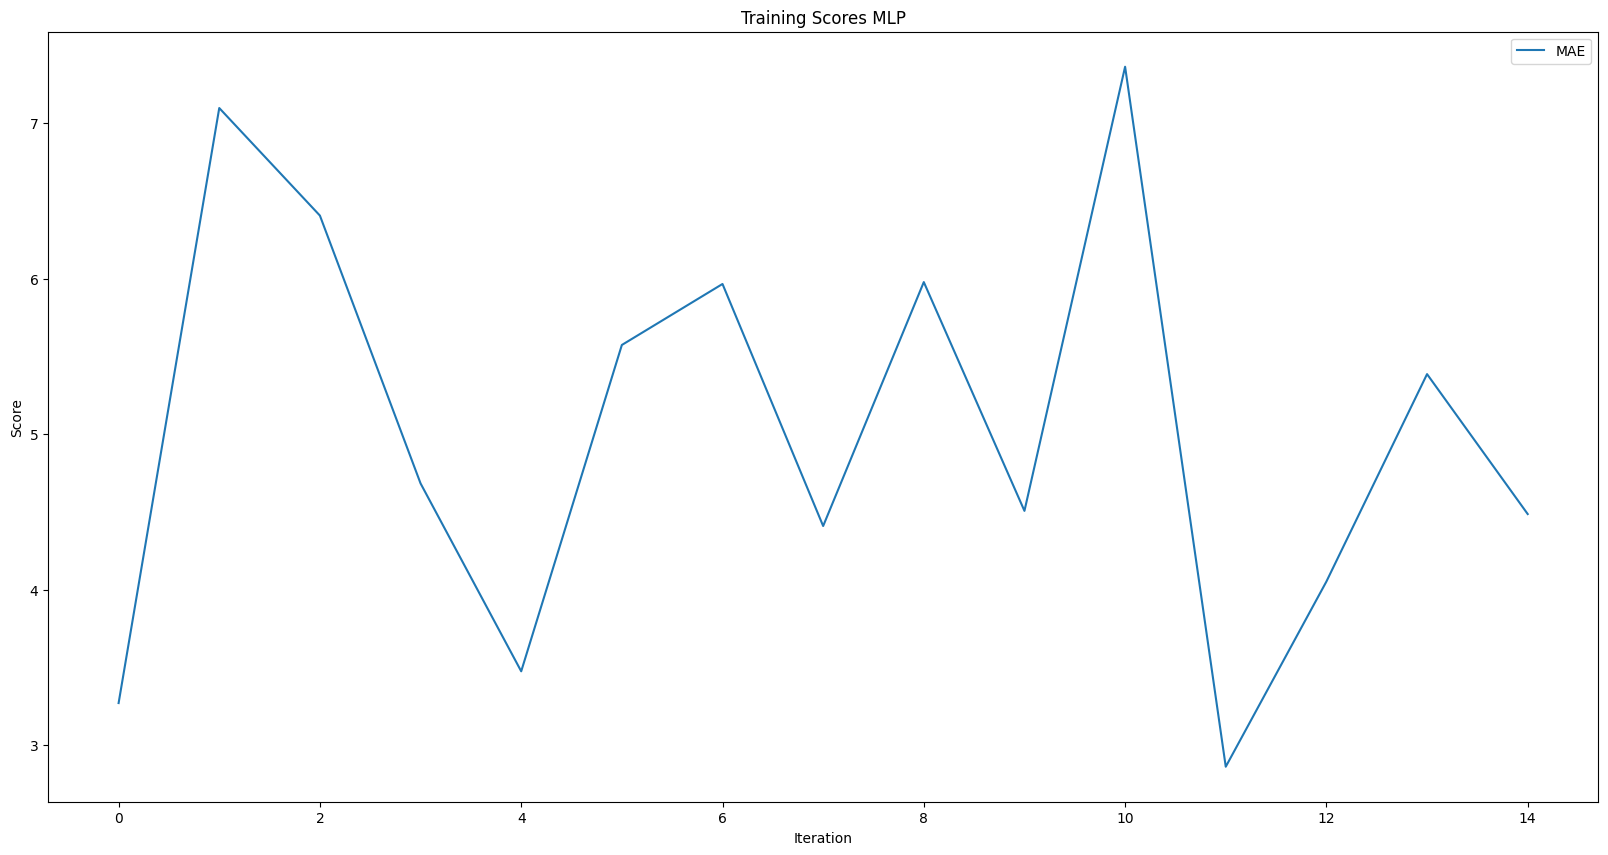

In [24]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(testResDataFrame['R2Score'])
plt.plot(testResDataFrame['MAE'])
#plt.plot(testResDataFrame['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [25]:
# Determine the IDX value where the MAE is smallest
minMaeIDX = testResDataFrame.loc[testResDataFrame['MAE']==testResDataFrame['MAE'].min()].index[0]

In [26]:
testResDataFrame.iloc[minMaeIDX]

HiddenLayers                                                       11
R2Score                                                      0.998093
MAE                                                          2.862667
MSE                                                         15.898268
MAPE                                                         0.011398
H5FileName                              mlp_64_11_model_std_all.keras
TrainHistory        <keras.callbacks.History object at 0x7f59f77ba...
TrainPredictions    [[248.11607], [107.996895], [273.0367], [140.4...
Name: 11, dtype: object

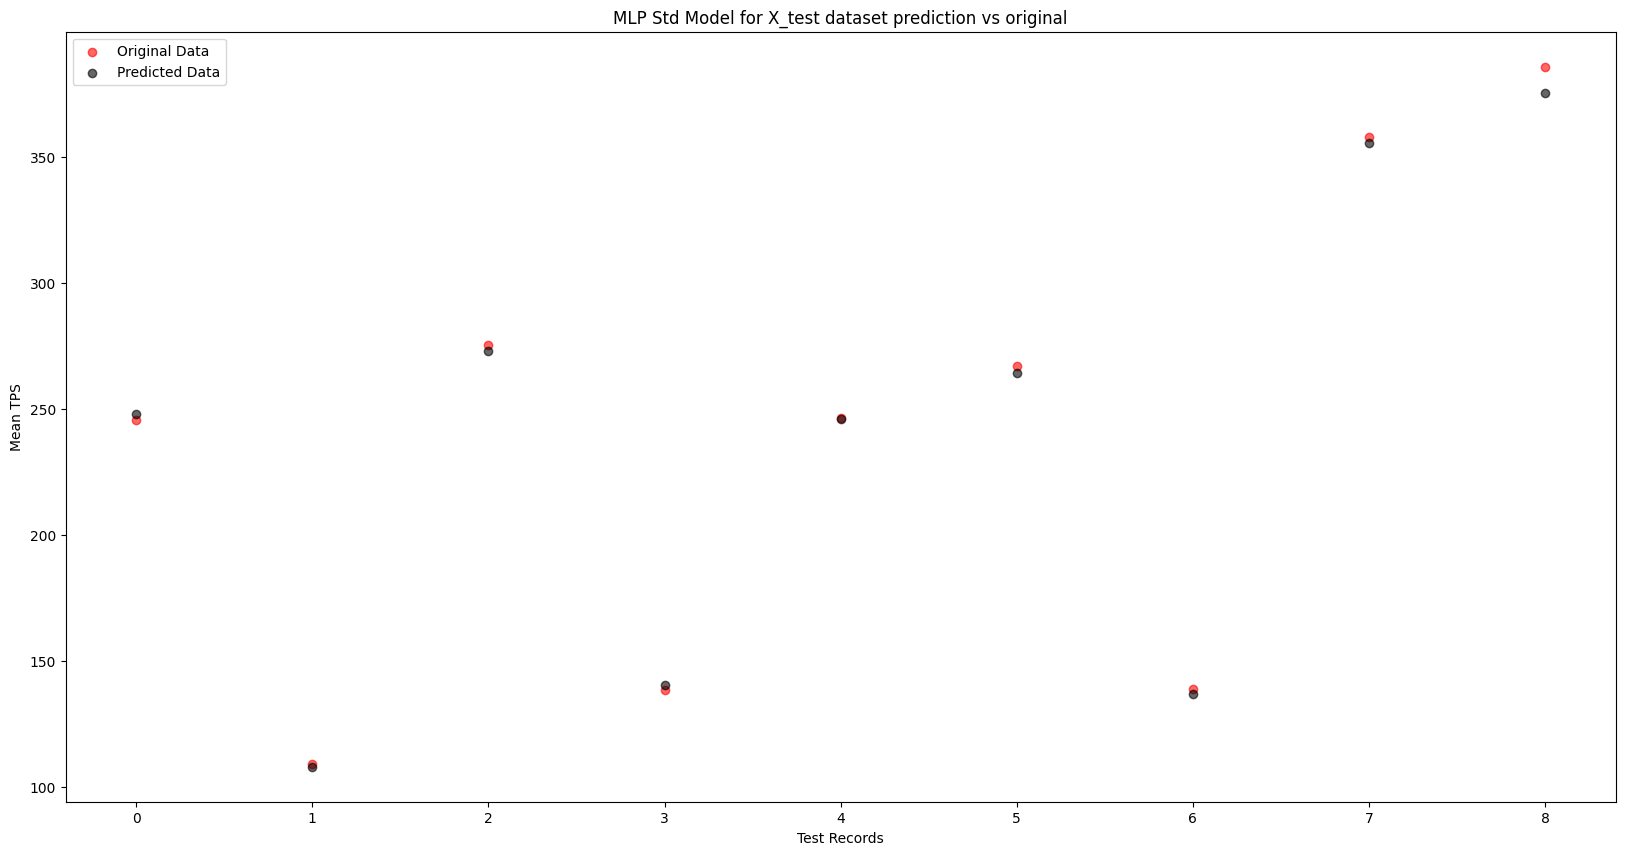

In [27]:
y_pred_MLP_std = testResDataFrame['TrainPredictions'][minMaeIDX]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original')
plt.legend()
plt.show()

In [40]:
MLFLOW_URI='http://mlflow-server.mlflow-server.svc.cluster.local:8080/'

In [41]:
os.environ["RAY_IGNORE_UNHANDLED_ERRORS"] = "1"

In [25]:
import logging
import ray
from codeflare_sdk import TokenAuthentication, Cluster, ClusterConfiguration
from codeflare_sdk import generate_cert

In [27]:
auth = TokenAuthentication(
    token = "sha256~Z9HYJBKFL-QIR36cYA0Hbq3u_ZoHOkggYJgKTyKJy8Q", # execute ocp whoami -t on the authenticated cluster to obtain the token
    server = "https://api.crc.testing:6443",
    skip_tls = False
)
auth.login()

Authenticated with certificate located at /etc/pki/tls/custom-certs/ca-bundle.crt


'Logged into https://api.crc.testing:6443'

In [29]:
# Create required TLS cert and export the environment variables to enable TLS
generate_cert.generate_tls_cert('raycluster-complete', 'raycluster2')

In [30]:
generate_cert.export_env('raycluster-complete', 'raycluster2')

In [52]:
ray_endpoint = 'ray://raycluster-complete-head-svc.raycluster2.svc.cluster.local:10001' # ensure your ray cluster URL is correct
ray.shutdown()
ray.init(address=ray_endpoint, logging_level=logging.ERROR, log_to_driver=False)

Python version:,3.9.15
Ray version:,2.6.3
Dashboard:,http://10.217.0.58:8265


In [53]:
import tf2onnx

In [54]:
import mlflow

In [55]:
from ray.air.integrations.mlflow import setup_mlflow

In [63]:
@ray.remote
def createRemoteModel(layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
        
    mlflow_exp_name = f'mlaspnew-1-{labelSet}-{loops}'
    mlflow_ray_config = None
    mlflow_ray = setup_mlflow(config=mlflow_ray_config,
                              tracking_uri=MLFLOW_URI,
                              registry_uri=MLFLOW_URI,
                              create_experiment_if_not_exists=True,
                              rank_zero_only=False,
                             experiment_name=mlflow_exp_name)
    
    print(f'Creating model using {loops} hidden layers of size = {layerSize} on set = {labelSet}.\n')
    model = Sequential()
    model.add(Dense(layerSize, kernel_initializer='normal',
                    input_dim=inputSize, activation='relu'))
    for j in range(loops):
        model.add(Dense(layerSize, 
                        kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal', 
                    activation='linear'))

    optmzr=Adam(learning_rate=0.001)    
    model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

    model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(loops) + '_model_std_' + labelSet + '.keras'
    checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                             monitor='val_loss',
                             verbose=verboseLevel,
                             save_best_only=True,
                             mode='min')
    callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

    history_MLP_std = model.fit(X_train, y_train,
                                batch_size=batchSize, 
                                validation_split=validationSplit, 
                                epochs=epochs, verbose=verboseLevel,
                                callbacks=callbacks_list_nn_std)

    #reload the best model!
    model_new = load_model(model_h5_name)
    #Predict
    y_pred_scaled = model_new.predict(X_test)
    #Evaluate metrics
    y_pred = targetScaler.inverse_transform(y_pred_scaled)
    r2_score = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    
    fig=plt.figure(figsize=(20,10))
    plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
    plt.scatter(range(y_pred.shape[0]),y_pred,label="Predicted Data", 
                alpha=0.6, c='black')
    plt.ylabel('Mean TPS')
    plt.xlabel('Test Records')
    plt.title('MLP StdScaler Model for X_test dataset prediction vs original')
    plt.legend()    
    with mlflow_ray.start_run(nested=True):
        mlflow_ray.log_figure(fig,f"{mlflow_exp_name}.png")

        mlflow_ray.log_param("batch_size", batchSize)
        mlflow_ray.log_param("layer_size", layerSize)
        mlflow_ray.log_param("hidden_layers", loops)
        mlflow_ray.log_param("activation_function", "relu")
        mlflow_ray.log_param("dense_kernel_initializer", "normal")
        mlflow_ray.log_param("epochs", epochs)
        mlflow_ray.log_param("learning_rate", 0.001)
        mlflow_ray.log_param("optimizer", "adam")

        mlflow_ray.log_metric("mae", mae)
        mlflow_ray.log_metric("mse", mse)
        mlflow_ray.log_metric("mape", mape)
        mlflow_ray.log_metric("r2_score", r2_score)

        model_onnx,_ = tf2onnx.convert.from_keras(model_new)
        mlflow_ray.onnx.log_model(model_onnx, f"model-{mlflow_exp_name}")

    row = [loops, r2_score, mae, mse, mape]

    return row


In [64]:
%%time

testResDataFrame2 = []
layerSize = 64
loops = 15


for i in range(loops):
    rowResult = createRemoteModel.remote(layerSize, i, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, labelSet='all_ray')
    testResDataFrame2.append(rowResult)


CPU times: user 8.8 ms, sys: 704 µs, total: 9.5 ms
Wall time: 13.5 ms


In [65]:
testResDataFrame2

[ClientObjectRef(4942ab37ee325960ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(0a95b5acadde928effffffffffffffffffffffff0500000001000000),
 ClientObjectRef(f9b2a1b2309c55c2ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(3eb11de787b259a9ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(f961cf6f8e5fc1a4ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(948b2608c769271dffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(e8f371ad8e3a5950ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(cd38da7afea09ef5ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(27cabaab71837ed7ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(1e43e533a26b5130ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(2e21b231dcc5a8d8ffffffffffffffffffffffff0500000001000000),
 ClientObjectRef(c84140960968ec17ffffffffffffffffffffffff0500000001000000)]

In [66]:
%%time

tResDF2 = ray.get(testResDataFrame2)

CPU times: user 679 ms, sys: 186 ms, total: 866 ms
Wall time: 1min 21s


In [67]:
colList2=colList.copy()

In [68]:
df = pd.DataFrame(tResDF2, columns=colList2[0:5])

In [69]:
df

,HiddenLayers,R2Score,MAE,MSE,MAPE
0,0,0.996559,4.708219,28.681958,0.021544
1,1,0.991006,7.021760,74.964442,0.030689
2,2,0.998529,2.821829,12.263163,0.015488
3,3,0.997793,3.797377,18.392896,0.019340
4,4,0.996416,4.045427,29.874877,0.017653
5,5,0.992029,5.968824,66.441260,0.039482
6,6,0.993621,5.109886,53.171640,0.017621
7,7,0.990467,6.697634,79.458060,0.044023
8,8,0.995461,4.485712,37.832363,0.018324
9,9,0.996197,4.635323,31.697117,0.024205


In [70]:
minMaeIDX_ray = df.loc[df['MAE']==df['MAE'].min()].index[0]

In [71]:
df.iloc[minMaeIDX_ray]

HiddenLayers     2.000000
R2Score          0.998529
MAE              2.821829
MSE             12.263163
MAPE             0.015488
Name: 2, dtype: float64

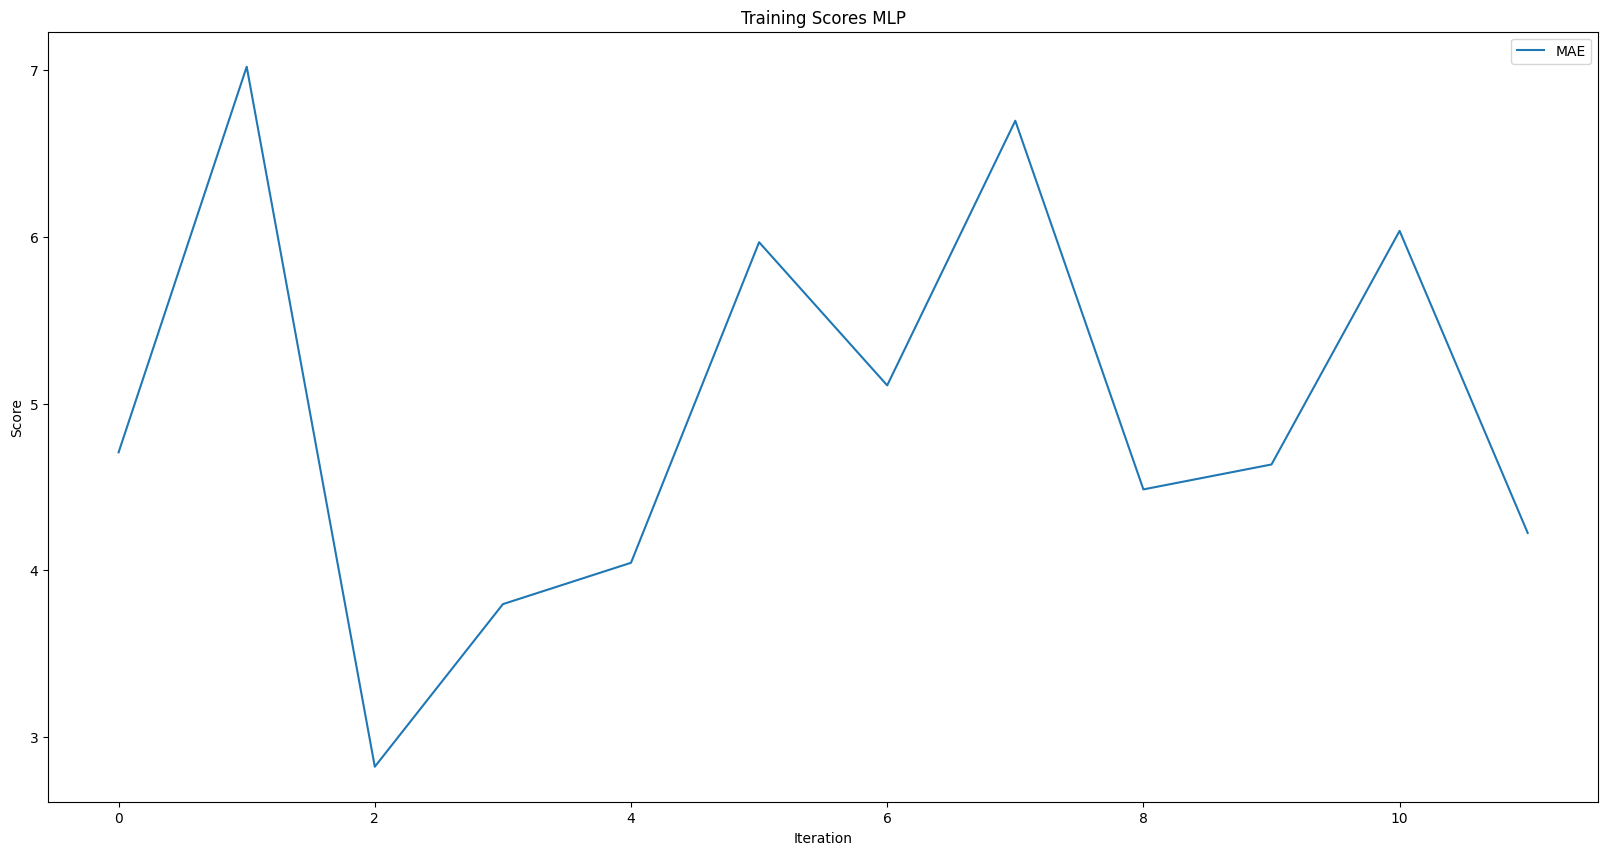

In [72]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(df['R2Score'])
plt.plot(df['MAE'])
#plt.plot(df['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [29]:
X_test.columns

Index(['asyncResp', 'asyncRespThreads', 'cThreads', 'jacptQSize',
       'jacptThreads', 'ltTargetSize', 'numConnections', 'timeoutSeconds'],
      dtype='object')

In [30]:
data.head(1)

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,timeoutSeconds
DateTime,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,5.0


In [31]:
record = [[True, 21, 277, 1712, 262, 7, 31, 5]]

In [32]:
test_rec = stdScaler.transform(record)

In [33]:
test_rec

array([[ 0.34815531, -0.16614866,  1.14391569, -0.53671704,  1.14391569,
        -0.29012346,  0.90504761,  0.30039875]])

In [34]:
test_model = load_model(testResDataFrame['H5FileName'][minMaeIDX])

In [35]:
test_pred = test_model.predict(test_rec)

1/1 [==============================] - 0s 74ms/step


In [36]:
test_pred

array([[0.87971044]], dtype=float32)

In [37]:
targetStdScaler.inverse_transform(test_pred)

array([[304.62128]], dtype=float32)

### Save the scalers for the inference calls

In [38]:
joblib.dump(targetStdScaler,'target_scaler.pkl')

['target_scaler.pkl']

In [39]:
joblib.dump(stdScaler,'standard_scaler.pkl')

['standard_scaler.pkl']

### Export to ONNX to run on the RHODS model server

In [40]:
model_onnx, _ = tf2onnx.convert.from_keras(test_model, output_path='tf_mlasp.onnx')

2025-05-01 01:27:31.690385: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-05-01 01:27:31.690607: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-01 01:27:31.748550: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-05-01 01:27:31.749063: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


### Upload model to S3 bucket

In [41]:
import boto3
import botocore

In [42]:
#S3 ODF GW client
s3_odf = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = 'default',
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [43]:
s3_odf.upload_file('tf_mlasp.onnx', bucket_name, 'models/tf_mlasp.onnx')

In [73]:
ray.shutdown()

In [44]:
s3_odf.upload_file('lt_results_2022-10-01.csv', bucket_name, 'data/lt_results_2022-10-01.csv')